# import 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from scipy.stats import shapiro

def get_p_stars(p_value):
    if p_value < 0.05:
        stars = '*' 
    if p_value < 0.01:
        stars = '**'
    if p_value < 0.001:
        stars = '***'
    if p_value < 0.0001:
        stars = '****'
    return stars

def plot_window_data(ax,dat1,dat2,ylabel):

    ax.plot(np.zeros(len(dat1)),dat1,'o', alpha = 0.4, markersize = 8, color = 'k',markeredgewidth=0)
    ax.boxplot(dat1, positions=[0.2], widths=0.1, patch_artist=True, boxprops=dict(facecolor='grey', color='k'), medianprops=dict(color='k'))

    ax.plot(0.7*np.ones(len(dat2)),dat2,'o', alpha = 0.4, markersize = 8, color = 'k',markeredgewidth=0)
    ax.boxplot(dat2, positions=[0.9], widths=0.1, patch_artist=True, boxprops=dict(facecolor='grey', color='k'), medianprops=dict(color='k'))

    ax.set_ylabel(ylabel) 

    ax.set_xlim(0.1,0.7)
    ax.set_xticks([0.1,0.8])
    ax.set_xlim(-0.5,1.3)
    ax.set_xticklabels(['replay','random'], fontsize = 7)

    #check if the data is normally distributed

    _,p = shapiro(dat1)
    _,p2 = shapiro(dat2)

    if p > 0.05 and p2 > 0.05:
        # do a paramtetic test 
        t_stat, p_value = stats.ttest_ind(dat1, dat2)
    else:
        # do a non parametric test 
        t_stat, p_value = stats.mannwhitneyu(dat1, dat2)
        
    ## add the p value to the plot
    if p_value < 0.05:
        stars = get_p_stars(p_value)
        ax.text(0.4, - 0.2, f'{stars} p = {p_value}', fontsize=8, ha='center', va='center', transform=ax.transAxes)
        
    else:
        ax.text(0.4, - 0.2, f'p = {p_value:.3f}', fontsize=8, ha='center', va='center', transform=ax.transAxes)


def compute_sliding_window_smooth(x, y, window_size=0.5, step_size=0.1):
    """
    Computes a smoothed curve using sliding window binning (mean ± std).
    
    Parameters:
        x (array-like): X-axis values.
        y (array-like): Y-axis values.
        window_size (float): Width of the sliding window.
        step_size (float): Step size between windows.
    
    Returns:
        tuple: (center_x, means, stds)
            - center_x: Array of x-values (bin centers).
            - means: Array of mean values for each window.
            - stds: Array of standard deviation values for each window.
    """
    x = np.array(x)
    y = np.array(y)

    # Compute bin centers
    x_min, x_max = np.min(x), np.max(x)
    centers = np.arange(x_min, x_max, step_size)

    # Initialize result containers
    means, stds, center_x = [], [], []

    for c in centers:
        mask = (x >= c - window_size / 2) & (x < c + window_size / 2)
        if np.any(mask):
            means.append(np.mean(y[mask]))
            stds.append(np.std(y[mask]))
            center_x.append(c)

    center_x = np.array(center_x)
    means = np.array(means)
    stds = np.array(stds)

    return center_x, means, stds

def plot_ETA(ax,average_signal,sems,random_average_signal,rand_sems):

    time_seconds = np.linspace(-1,1,5000)
    ax.plot(time_seconds,average_signal,color = 'red', label = 'replay aligned', alpha = 0.8)
    ax.plot(time_seconds,random_average_signal, color = 'blue', label = 'random non replay times', alpha = 0.8)
    ax.axvline(0,color= 'k', alpha = 0.2)
    ax.set_title('spindle band event triggered av.')

    upper = average_signal + sems
    lower = average_signal - sems
    ax.fill_between(time_seconds,(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='red',
        linewidth=1, linestyle='dashdot', antialiased=True)
    
    upper = random_average_signal + rand_sems
    lower = random_average_signal - rand_sems
    ax.fill_between(time_seconds,(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='blue',
        linewidth=1, linestyle='dashdot', antialiased=True)
    
    ax.legend(loc='lower left', fontsize = 6)
    
    ax.set_ylabel('spindle band power (zscore)')
    ax.set_xlabel('time (s)')
    
    return time_seconds

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name,bbox_inches=0,transparent = True)

# main

In [2]:
path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\"

# set variables 
n = 0
# spinlde rates
spindle_rates = []
# delta/spindle power cross correlations
spindle_z_x_corr,spindle_z_temporal_shuffle,spindle_z_phase_shuffle = [], [], []
delta_z_x_corr,delta_z_temporal_shuffle,delta_z_phase_shuffle = [],[],[]
spectral_power_time_lags = []
# spindle events cross correlations
spindle_events_z_x_corr_replay,spindle_events_z_temporal_shuffle_replay,spindle_events_z_phase_shuffle_replay,spindle_events_time_lags_replay = [],[],[],[]
# linkage data
spindle_linkage_distance,spindle_linkage_distance_random_replay,spindle_linkage_distance_random_spindles = [],[],[]
#psth data
event_by_event_zscored_psth_spindles,event_by_event_psth_spindle_bins,event_by_event_zscored_psth_replay,event_by_event_psth_replay_bins = [],[],[],[]
# proportion of replay linked to spindles
proportion_of_spin_linked_replay_total_nrem_rem = []
# replay window data
replay_window_results = []
rand_replay_window_results = []
# spindle amplitude and magnitude vs proximty to replay
distance_to_replay,chunk_spind_peaks,chunk_spind_lengths,chunk_spind_av_magnitudes,chunk_spind_total_magnitude = [],[],[],[],[]
# event triggered average data
average_signal,average_signal_rect,peak_algined_average_signal,peak_sems = [],[],[],[]
# random event triggered average data
random_average_signal,random_average_signal_rect,random_peak_algined_average_signal,random_peak_sems = [],[],[],[]
# logistic regression results
logistic_regression_results_objects = []
original_auc,shuffled_aucs = [], []
# unit consistency results 
unit_consistency_awake, spindle_linkage_distance_vs_consistency, proportion_spindle_linked_vs_consistency = [], [], []
# logistic regression for replay predicting spindle linkage
replay_predicts_linkage_logistic_regression_results_object = []
replay_predicts_linkage_original_auc, replay_predicts_linkage_shuffled_aucs = [], []
# new regression for replay seq types predicting spindle linkage distance
replay_spindle_linkage_r2,replay_spindle_linkage_r2_shuffle = [], []
# new regression for general replay features predicting spindle linkage
general_replay_features_spindle_linkage_r2_regression,general_replay_features_spindle_linkage_permutation_r2_regression,general_replay_features_spindle_linkage_coefficients_regression_df = [],[],[]
# raw-ish data for replay features and spindle linkage values 
replay_features_df, spindle_linkage_distances = [],[]

for index, mouse_file in enumerate(os.listdir(path)):
    print('----------')
    print(mouse_file)
    print(index)
    current_mouse_p = os.path.join(path, mouse_file)
    if 'analysis' in os.listdir(current_mouse_p):
        current_mouse_path = os.path.join(current_mouse_p, r"analysis\\")
        
        # add to the n
        n= n+1
        
        # spindle rates 
        spindle_rates += [pd.read_csv(current_mouse_path + 'spindle_rates.csv')]

        # load data for cross correlations
        # delta power data 
        delta_z_x_corr += [np.load(current_mouse_path + 'delta_z_x_corr.npy', allow_pickle=True)]
        delta_z_temporal_shuffle += [np.load(current_mouse_path + 'delta_z_temporal_shuffle.npy', allow_pickle=True)]
        delta_z_phase_shuffle += [np.load(current_mouse_path + 'delta_z_phase_shuffle.npy', allow_pickle=True)]
        # spindle power data 
        spindle_z_x_corr += [np.load(current_mouse_path + 'spindle_z_x_corr.npy', allow_pickle=True)]
        spindle_z_temporal_shuffle += [np.load(current_mouse_path + 'spindle_z_temporal_shuffle.npy', allow_pickle=True)]
        spindle_z_phase_shuffle += [np.load(current_mouse_path + 'spindle_z_phase_shuffle.npy', allow_pickle=True)]
        
        spectral_power_time_lags += [np.load(current_mouse_path + 'spectral_power_time_lags.npy', allow_pickle=True)]

        # individual spindle occurance cross correlation        
        spindle_events_z_x_corr_replay += [np.load(current_mouse_path + 'spindle_events_z_x_corr_replay.npy')]
        spindle_events_z_temporal_shuffle_replay += [np.load(current_mouse_path + 'spindle_events_z_temporal_shuffle_replay.npy')]
        spindle_events_z_phase_shuffle_replay += [np.load(current_mouse_path + 'spindle_events_z_phase_shuffle_replay.npy')]
        spindle_events_time_lags_replay += [np.load(current_mouse_path + 'spindle_events_time_lags_replay.npy')]
        
        # spindle linkage analysis 
        spindle_linkage_distance += [np.load(current_mouse_path + 'spindle_linkage_distance.npy')]
        spindle_linkage_distance_random_replay += [np.load(current_mouse_path + 'spindle_linkage_distance_random_replay.npy')]
        spindle_linkage_distance_random_spindles += [np.load(current_mouse_path + 'spindle_linkage_distance_random_spindles.npy')]
        
        ## psth data
        event_by_event_zscored_psth_spindles += [np.load(current_mouse_path + 'event_by_event_zscored_psth_spindles.npy')]
        event_by_event_psth_spindle_bins += [np.load(current_mouse_path + 'event_by_event_psth_spindle_bins.npy')]
        event_by_event_zscored_psth_replay += [np.load(current_mouse_path + 'event_by_event_zscored_psth_replay.npy')]
        event_by_event_psth_replay_bins += [np.load(current_mouse_path + 'event_by_event_psth_replay_bins.npy')]
            
        # proportion of replay linked to spindles
        proportion_of_spin_linked_replay_total_nrem_rem += [np.load(current_mouse_path + 'proportion_of_spin_linked_replay_total_nrem_rem.npy')]

        # replay window data
        replay_window_results +=[np.load(current_mouse_path + 'replay_window_results.npy', allow_pickle=True)]
        rand_replay_window_results += [np.load(current_mouse_path + 'rand_replay_window_results.npy', allow_pickle=True)]
        
        #### spindle amplitude and magnitude vs proximty to replay
        distance_to_replay += [np.load(current_mouse_path + 'distance_to_replay.npy' )]
        chunk_spind_peaks += [np.load(current_mouse_path + 'chunk_spind_peaks.npy')]
        chunk_spind_lengths += [np.load(current_mouse_path + 'chunk_spind_lengths.npy')]
        chunk_spind_av_magnitudes += [np.load(current_mouse_path + 'chunk_spind_av_magnitudes.npy')]
        chunk_spind_total_magnitude += [np.load(current_mouse_path +  'chunk_spind_total_magnitude.npy')]
                
        # event triggered average data     
        average_signal += [np.load(current_mouse_path + 'average_signal.npy', allow_pickle=True)]
        average_signal_rect += [np.load(current_mouse_path + 'average_signal_rect.npy', allow_pickle=True)]
        peak_algined_average_signal += [np.load(current_mouse_path + 'peak_algined_average_signal.npy', allow_pickle=True)]
        peak_sems += [np.load(current_mouse_path + 'peak_sems.npy', allow_pickle=True)]
        random_average_signal += [np.load(current_mouse_path + 'random_average_signal.npy', allow_pickle=True)]
        random_average_signal_rect += [np.load(current_mouse_path + 'random_average_signal_rect.npy', allow_pickle=True)]
        random_peak_algined_average_signal += [np.load(current_mouse_path + 'random_peak_algined_average_signal.npy', allow_pickle=True)]
        random_peak_sems += [np.load(current_mouse_path + 'random_peak_sems.npy', allow_pickle=True)]
        
        # load logistic regression results
        with open(current_mouse_path + 'logistic_regression_results_object.pkl', 'rb') as f:
            results = pickle.load(f)
            logistic_regression_results_objects += [results]
        # load auc values
        with open(current_mouse_path + 'original_auc.txt', 'r') as f:
            original_auc += [float(f.read())]

        with open(current_mouse_path + 'shuffled_aucs.pkl', 'rb') as f:
            shuffled_aucs += [pickle.load(f)]
            
        # load unit consistency data
        unit_consistency_awake += [np.load(current_mouse_path + 'unit_consistency_awake.npy',allow_pickle=True)]
        spindle_linkage_distance_vs_consistency += [np.load(current_mouse_path + 'spindle_linkage_distance_vs_consistency.npy',allow_pickle=True)]
        proportion_spindle_linked_vs_consistency += [np.load(current_mouse_path + 'proportion_spindle_linked_vs_consistency.npy',allow_pickle=True)]
        
        # # load logistic regression for replay predicting spindle linkage
        # with open(current_mouse_path + 'replay_predicts_linkage_logistic_regression_results_object.pkl', 'rb') as f:
        #     results = pickle.load(f)
        #     replay_predicts_linkage_logistic_regression_results_object += [results]
        # # load auc values
        # with open(current_mouse_path + 'replay_predicts_linkage_original_auc.txt', 'r') as f:
        #     replay_predicts_linkage_original_auc += [float(f.read())]

        # with open(current_mouse_path + 'replay_predicts_linkage_shuffled_aucs.pkl', 'rb') as f:
        #     replay_predicts_linkage_shuffled_aucs += [pickle.load(f)]
            
        # new logistic regression for replay predicting spindle linkage
        
        # data from regression for seq type predicting spindle linkage
        replay_spindle_linkage_r2 += [np.load(current_mouse_path + 'replay_spindle_linkage_r2.npy')]
        replay_spindle_linkage_r2_shuffle += [np.load(current_mouse_path + 'replay_spindle_linkage_r2_shuffle.npy')]
        
        ## regression for general replay features predicting spindle linkage
        general_replay_features_spindle_linkage_r2_regression += [np.load(current_mouse_path + 'general_replay_features_spindle_linkage_r2_regression.npy')]
        general_replay_features_spindle_linkage_permutation_r2_regression += [np.load(current_mouse_path + 'general_replay_features_spindle_linkage_permutation_r2_regression.npy')]
        general_replay_features_spindle_linkage_coefficients_regression_df += [pd.read_csv(current_mouse_path + 'general_replay_features_spindle_linkage_coefficients_regression_df.csv')]
                
                
        ## load in data for replay features and spindle linkage distance    
        replay_features_df += [pd.read_csv(current_mouse_path + 'replay_features_df.csv')]
        spindle_linkage_distances += [np.load(current_mouse_path+'spindle_linkage_distances.npy')]

        


----------
136_1_3
0
----------
136_1_4
1
----------
148_2_2
2
----------
149_1_1
3
----------
178_1_4
4
----------
178_1_5
5
----------
178_1_6
6
----------
178_1_7
7
----------
178_1_8
8
----------
178_1_9
9
----------
178_2_1
10
----------
178_2_2
11
----------
178_2_4
12
----------
269_1_1
13
----------
269_1_3
14
----------
269_1_4
15
----------
269_1_7
16
----------
270_1_3
17
----------
270_1_5
18
----------
270_1_6
19
----------
seq006_1_11
20


# new regression analysis 

plot the significance - can we predict when spindles will occur?

Text(0.5, 0, 'z-scored r2')

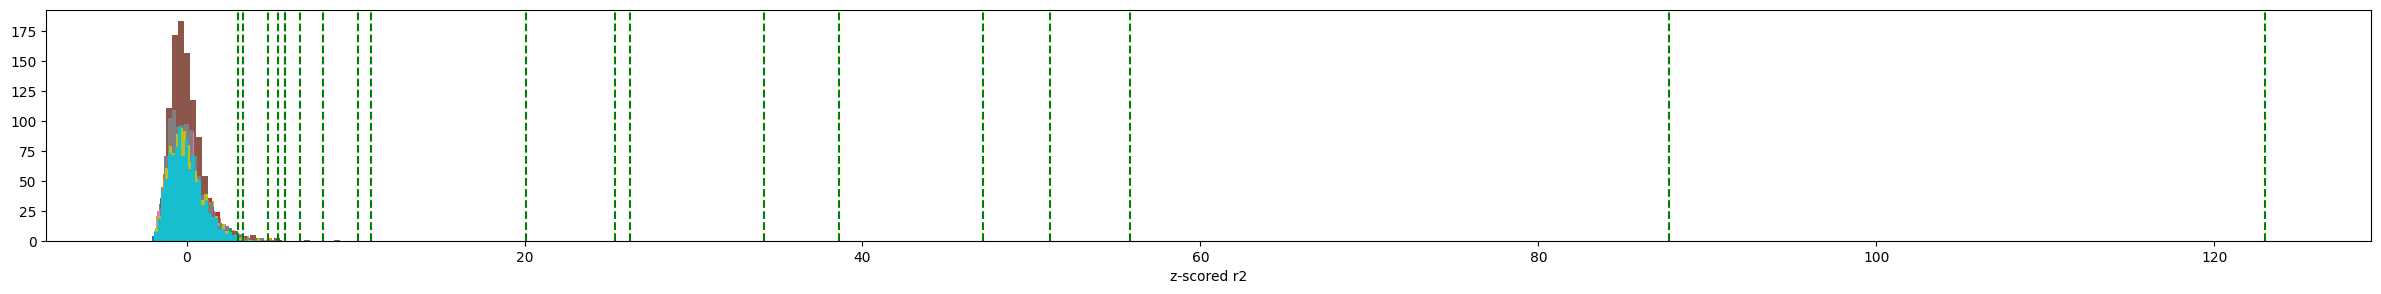

In [413]:
## first show the relationship - ie. there is one. it is significant across mice

# work out which ones are significant:
signficant = []
for i, item in enumerate(general_replay_features_spindle_linkage_permutation_r2_regression):
    if not i == 11:  # skip the 11th index as it is was broken
        # get 95th percentile of the shuffled r2s
        percentile_95 = np.percentile(item, 95)
        if general_replay_features_spindle_linkage_r2_regression[i] > percentile_95:
            signficant += [True]
        else:
            signficant += [False]
        
# plot the r2 to show significance
real_r2_zscored = []
shuffle_r2_zscored = []
for i,item in enumerate(general_replay_features_spindle_linkage_permutation_r2_regression):
    
    if not i == 11:  # skip the 11th index as it is was broken
        shuffled_r2s = item
        real_r2 = general_replay_features_spindle_linkage_r2_regression[i]
        
        # Compute mean and std of the shuffle distribution
        mean_shuffle = np.mean(shuffled_r2s)
        std_shuffle = np.std(shuffled_r2s)
        # Z-score
        
        real_r2_zscored += [(real_r2 - mean_shuffle) / std_shuffle]
        
        shuffle_r2_zscored += [scipy.stats.zscore(shuffled_r2s)]
    
fig, ax = plt.subplots(figsize=(30, 3))
for i in range(len(shuffle_r2_zscored)):
    if not shuffle_r2_zscored[i][0] == 'nan':
        ax.hist(shuffle_r2_zscored[i],30)
        if signficant[i]:
            ax.axvline(real_r2_zscored[i], color='green', linestyle='--')
        else:
            ax.axvline(real_r2_zscored[i], color='red', linestyle='--')
            
ax.set_xlabel('z-scored r2')

how strong is this effect? - how well can we predict? how much of the variance can we explain

Text(0, 0.5, 'r2 value')

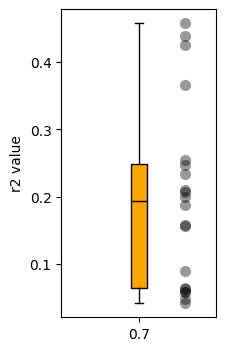

In [414]:
# get rid of the 11th item because its broken 
cleaned_r2_regression = general_replay_features_spindle_linkage_r2_regression[:11] + general_replay_features_spindle_linkage_r2_regression[12:]

# make it into a list
cleaned_r2_regression = [float(item) for item in cleaned_r2_regression]

# only keep the significant ones
cleaned_r2_regression = np.array(cleaned_r2_regression)[signficant]   


fig, ax = plt.subplots(figsize=(2, 4))
ax.plot(np.ones(len(cleaned_r2_regression)), cleaned_r2_regression, 'o', alpha=0.4, markersize=8, color='k', markeredgewidth=0)
ax.boxplot(cleaned_r2_regression, positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='orange', color='k'), medianprops=dict(color='k'))
ax.set_ylabel('r2 value')

what coefficients are relevant

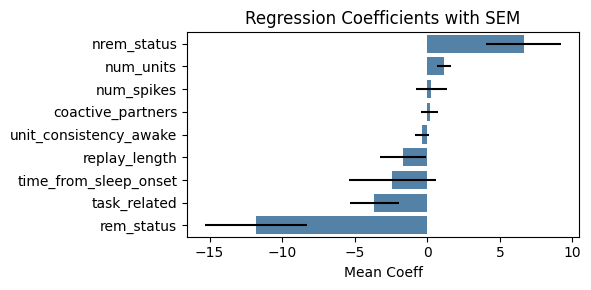

In [416]:
# Convert each df in the list to a dict: {variable: coef}
coefficients_list = [
    df.set_index("variable")["coef"].to_dict()
    for df in general_replay_features_spindle_linkage_coefficients_regression_df
]

# Combine all dicts into a DataFrame
df_params = pd.DataFrame(coefficients_list)

# Drop the constant term if it exists
df_plot = df_params.drop(columns='const', errors='ignore')

# Compute mean and SEM for each parameter
mean_values = df_plot.mean()
sem_values = df_plot.sem()

# Sort by mean values
sorted_indices = mean_values.sort_values(ascending=False).index
mean_sorted = mean_values[sorted_indices]
sem_sorted = sem_values[sorted_indices]

# Plot with error bars
plt.figure(figsize=(6, 3))
sns.barplot(
    x=mean_sorted.values,
    y=mean_sorted.index,
    xerr=sem_sorted.values,
    color='steelblue',
    capsize=0.2,
    errcolor='black',
    errwidth=1
)
plt.xlabel('Mean Coeff')
plt.title('Regression Coefficients with SEM')
plt.tight_layout()
plt.show()

run a regression on early nrem data? 



plot spindle linkage vs time from sleep start

In [409]:
def plot_delay_vs_linkage(delay_times, scores):

    # Define bins for delay times (e.g. every 0.5s)
    bin_edges = np.arange(0, round(max(delay_times)), 100)

    # Digitize: assigns each delay to a bin index
    bin_indices = np.digitize(delay_times, bin_edges)

    # Compute average score per bin
    average_scores = []
    bin_centers = []

    for i in range(1, len(bin_edges)):
        in_bin = scores[bin_indices == i]
        if len(in_bin) > 0:
            average_scores.append(np.mean(in_bin))
            bin_centers.append((bin_edges[i-1] + bin_edges[i]) / 2)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(bin_centers, average_scores, 'o')
    plt.xlabel('Delay Time (binned)')
    plt.ylabel('Average Score')
    plt.title('Average Score by Delay Time')
    plt.grid(True)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

nrem_mask = sequence_replay_df.nrem_status == 1

# Example data
delay_times = sequence_replay_df.time_from_sleep_onset.values[nrem_mask]
scores = sequential_spin_coseness_df.spindle_closeness.values[nrem_mask]

# Define bins for delay times (e.g. every 0.5s)
bin_edges = np.arange(0, round(max(delay_times)), 20)

# Digitize: assigns each delay to a bin index
bin_indices = np.digitize(delay_times, bin_edges)

# Compute average score per bin
average_scores = []
bin_centers = []

for i in range(1, len(bin_edges)):
    in_bin = scores[bin_indices == i]
    if len(in_bin) > 0:
        average_scores.append(np.mean(in_bin))
        bin_centers.append((bin_edges[i-1] + bin_edges[i]) / 2)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(bin_centers, average_scores, width=np.diff(bin_edges)[0], align='center', edgecolor='black')
plt.xlabel('Delay Time (binned)')
plt.ylabel('Average Score')
plt.title('Average Score by Delay Time')
plt.grid(True)
plt.show()

In [ ]:
# change the above so that the lines are colored differently based on significance
# plot out the r squared values (mark the ones that are significant)
# plot r squared values vs distance from sleep start?
# plot 

In [ ]:
# seems like there might be some interplay between length of time from sleep start and the effect 
# intially the spindles might be prioritised to some features of replay, but as time goes on the linkage dissapears

## I need to plot linkage vs time from sleep onset
# then plot 

# spindle rate in rem vs nrem? 

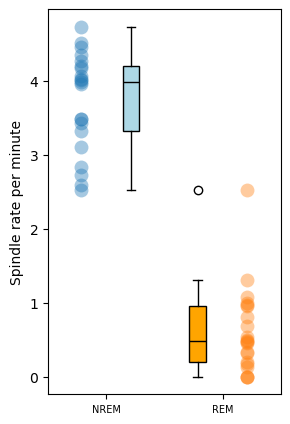

In [4]:
# nrem_epm = []
# rem_epm = []
# for mouse_df in spindle_rates:
#     nrem_epm += [mouse_df.nrem_epm.values[0]]
#     rem_epm += [mouse_df.rem_epm.values[0]]
    
# state_rates_df = pd.DataFrame({'mouse_id':os.listdir(path)[0:21],'nre_epm':nrem_epm,'rem_epm':rem_epm})
# state_rates_df.to_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\plotting_data\\" + 'state_rates_df.csv', index=False)
    
state_rates_df = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\plotting_data\\" + 'state_rates_df.csv')

nrem_epm= state_rates_df.nre_epm.values
rem_epm = state_rates_df.rem_epm.values

fig,ax,= plt.subplots(1, 1,figsize=(3, 5))
ax.plot(np.zeros(len(nrem_epm)),nrem_epm,'o', alpha = 0.4, markersize = 10, markeredgewidth = 0)
ax.plot(np.ones(len(rem_epm)),rem_epm,'o', alpha = 0.4, markersize = 10, markeredgewidth = 0)
# add a box plot
ax.boxplot(nrem_epm, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='lightblue', color='k'), medianprops=dict(color='k'))
ax.boxplot(rem_epm, positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='orange', color='k'), medianprops=dict(color='k'))
# # remove the x ticks
ax.set_xticks([0.15,0.85])
# add x tick labels 
ax.set_xticklabels(['NREM','REM'], fontsize = 7)
ax.set_ylabel('Spindle rate per minute')

SaveFig('spindle_rpm.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

# power band cross correlations

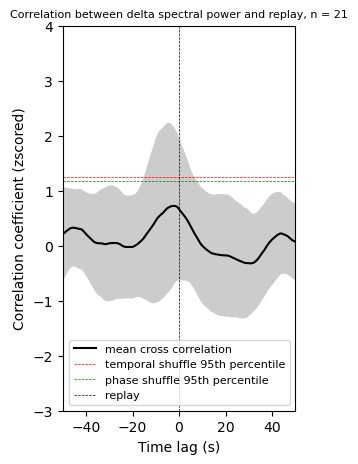

In [5]:
## plot cross correlations DELTA POWER

mean_delta_x_corr = np.mean(delta_z_x_corr,axis=0)
std_delta_x_corr = np.std(delta_z_x_corr,axis=0)
mean_delta_temporal_shuffle = np.mean(delta_z_temporal_shuffle,axis=0)
str_delta_temporal_shuffle = np.std(delta_z_temporal_shuffle,axis=0)
mean_delta_phase_shuffle = np.mean(delta_z_phase_shuffle,axis=0)
std_delta_phase_shuffle = np.std(delta_z_phase_shuffle,axis=0)

time_lags = np.mean(spectral_power_time_lags,axis=0)

fig, ax = plt.subplots(figsize=(3, 5))

ax.plot(time_lags,mean_delta_x_corr, label='mean cross correlation', color='k')
ax.fill_between(time_lags, mean_delta_x_corr - std_delta_x_corr, mean_delta_x_corr + std_delta_x_corr, alpha=0.2, color='k', linewidth = 0)

# get 95th percentile of shuffle data
mean_spin_events_temporal_shuffle_95 = np.percentile(mean_delta_temporal_shuffle, 95)
mean_spin_events_phase_shuffle_95 = np.percentile(mean_delta_phase_shuffle, 95)
ax.axhline(mean_spin_events_temporal_shuffle_95, color='red', lw=0.5, ls='--', label = 'temporal shuffle 95th percentile')
ax.axhline(mean_spin_events_phase_shuffle_95, color='green', lw=0.5, ls='--', label = 'phase shuffle 95th percentile')

# ax.plot(time_lags,mean_delta_temporal_shuffle, label='mean temporal shuffle', color='red')
# ax.fill_between(time_lags, mean_delta_temporal_shuffle - str_delta_temporal_shuffle, mean_delta_temporal_shuffle + str_delta_temporal_shuffle, alpha=0.2, color='red')

# ax.plot(time_lags,mean_delta_phase_shuffle, label='mean phase shuffle', color='green')
# ax.fill_between(time_lags, mean_delta_phase_shuffle - std_delta_phase_shuffle, mean_delta_phase_shuffle + std_delta_phase_shuffle, alpha=0.2, color='green')

ax.axvline(0, color='black', lw=0.5, ls='--', label = 'replay')
ax.set_xlabel('Time lag (s)', size = 10)
ax.set_ylabel('Correlation coefficient (zscored)', size = 10)
ax.set_title(f'Correlation between delta spectral power and replay, n = {n}', fontsize = 8)
ax.set_xlim(-50,50)
ax.set_ylim(-3,4)
ax.legend(loc='lower right', fontsize=8)


SaveFig('delta_spectral_power_xcor.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

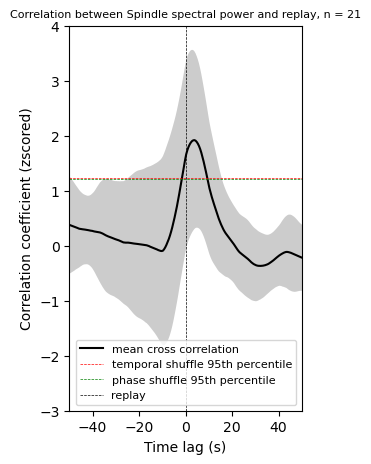

In [6]:
## plot cross correlations SPINDLE POWER

mean_spin_x_corr = np.mean(spindle_z_x_corr,axis=0)
std_spin_x_corr = np.std(spindle_z_x_corr,axis=0)
mean_spin_temporal_shuffle = np.mean(spindle_z_temporal_shuffle,axis=0)
str_spindle_temporal_shuffle = np.std(spindle_z_temporal_shuffle,axis=0)
mean_spin_phase_shuffle = np.mean(spindle_z_phase_shuffle,axis=0)
std_spin_phase_shuffle = np.std(spindle_z_phase_shuffle,axis=0)

time_lags = np.mean(spectral_power_time_lags,axis=0)

fig, ax = plt.subplots(figsize=(3, 5))

ax.plot(time_lags,mean_spin_x_corr, label='mean cross correlation', color='k')
ax.fill_between(time_lags, mean_spin_x_corr - std_spin_x_corr, mean_spin_x_corr + std_spin_x_corr, alpha=0.2, color='k', linewidth = 0)

# get 95th percentile of shuffle data
mean_spin_events_temporal_shuffle_95 = np.percentile(mean_spin_temporal_shuffle, 95)
mean_spin_events_phase_shuffle_95 = np.percentile(mean_spin_phase_shuffle, 95)
ax.axhline(mean_spin_events_temporal_shuffle_95, color='red', lw=0.5, ls='--', label = 'temporal shuffle 95th percentile')
ax.axhline(mean_spin_events_phase_shuffle_95, color='green', lw=0.5, ls='--', label = 'phase shuffle 95th percentile')

# ax.plot(time_lags,mean_spin_temporal_shuffle, label='mean temporal shuffle', color='red')
# ax.fill_between(time_lags, mean_spin_temporal_shuffle - str_spindle_temporal_shuffle, mean_spin_temporal_shuffle + str_spindle_temporal_shuffle, alpha=0.2, color='red')

# ax.plot(time_lags,mean_spin_phase_shuffle, label='mean phase shuffle', color='green')
# ax.fill_between(time_lags, mean_spin_phase_shuffle - std_spin_phase_shuffle, mean_spin_phase_shuffle + std_spin_phase_shuffle, alpha=0.2, color='green')

ax.axvline(0, color='black', lw=0.5, ls='--', label = 'replay')
ax.set_xlabel('Time lag (s)', size = 10)
ax.set_ylabel('Correlation coefficient (zscored)', size = 10)
ax.set_title(f'Correlation between Spindle spectral power and replay, n = {n}', fontsize = 8)
ax.set_xlim(-50,50)
ax.set_ylim(-3,4)
ax.legend(loc='lower right', fontsize=8)

SaveFig('spindle_spectral_power_xcor.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

# individual spindle occurance cross correlation

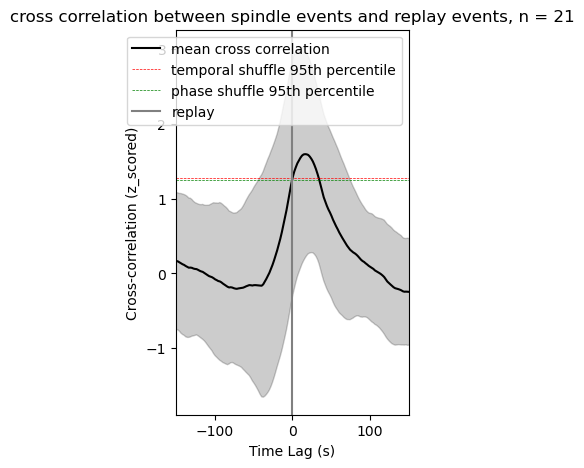

In [7]:


mean_spin_events_x_corr = np.mean(spindle_events_z_x_corr_replay,axis=0)
std_spin_events_x_corr = np.std(spindle_events_z_x_corr_replay,axis=0)
mean_spin_events_temporal_shuffle = np.mean(spindle_events_z_temporal_shuffle_replay,axis=0)
str_spindle_events_temporal_shuffle = np.std(spindle_events_z_temporal_shuffle_replay,axis=0)
mean_spin_events_phase_shuffle = np.mean(spindle_events_z_phase_shuffle_replay,axis=0)
std_spin_events_phase_shuffle = np.std(spindle_events_z_phase_shuffle_replay,axis=0)

# i = 4
# mean_spin_events_x_corr = spindle_events_z_x_corr_replay[i]
# std_spin_events_x_corr = np.std(spindle_events_z_x_corr_replay[i])
# mean_spin_events_temporal_shuffle = spindle_events_z_temporal_shuffle_replay[i]
# str_spindle_events_temporal_shuffle = np.std(spindle_events_z_temporal_shuffle_replay[i])
# mean_spin_events_phase_shuffle = spindle_events_z_phase_shuffle_replay[i]
# std_spin_events_phase_shuffle = np.std(spindle_events_z_phase_shuffle_replay[i])


time_lags = np.mean(spindle_events_time_lags_replay,axis=0)

fig, ax = plt.subplots(figsize=(3, 5))

ax.plot(time_lags,mean_spin_events_x_corr, label='mean cross correlation', color='k')
ax.fill_between(time_lags, mean_spin_events_x_corr - std_spin_events_x_corr, mean_spin_events_x_corr + std_spin_events_x_corr, alpha=0.2, color='k')

# get 95th percentile of shuffle data
mean_spin_events_temporal_shuffle_95 = np.percentile(mean_spin_events_temporal_shuffle, 95)
mean_spin_events_phase_shuffle_95 = np.percentile(mean_spin_events_phase_shuffle, 95)
ax.axhline(mean_spin_events_temporal_shuffle_95, color='red', lw=0.5, ls='--', label = 'temporal shuffle 95th percentile')
ax.axhline(mean_spin_events_phase_shuffle_95, color='green', lw=0.5, ls='--', label = 'phase shuffle 95th percentile')

# ax.plot(time_lags,mean_spin_events_temporal_shuffle, label='mean temporal shuffle', color='red')
# ax.fill_between(time_lags, mean_spin_events_temporal_shuffle - str_spindle_events_temporal_shuffle, mean_spin_events_temporal_shuffle + str_spindle_events_temporal_shuffle, alpha=0.2, color='red')

# ax.plot(time_lags,mean_spin_events_phase_shuffle, label='mean phase shuffle', color='green')
# ax.fill_between(time_lags, mean_spin_events_phase_shuffle - std_spin_events_phase_shuffle, mean_spin_events_phase_shuffle + std_spin_events_phase_shuffle, alpha=0.2, color='green')
ax.set_xlim(-150,150)
ax.axvline(0,color = 'grey', label = 'replay')
ax.set_xlabel('Time Lag (s)')
ax.set_ylabel('Cross-correlation (z_scored)')
ax.set_title(f'cross correlation between spindle events and replay events, n = {n}')
ax.legend()

# Linkage analysis - Time Lag from replay to closest spindle

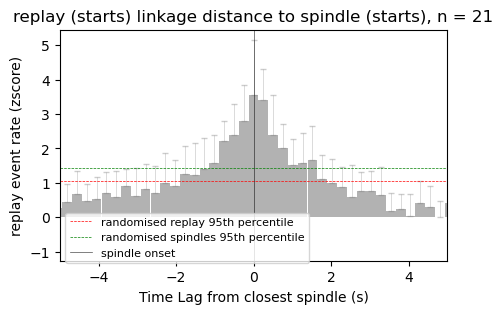

In [8]:
import scipy 
def bin_and_normalise(spindle_linkage_distance,bins):
    normed_x_all = []
    for i in range(len(spindle_linkage_distance)):
        x = plt.hist(spindle_linkage_distance[i],bins)
        plt.close()
        # normed_x_all += [x[0]/sum(x[0])]
        normed_x_all += [scipy.stats.zscore(x[0])]
    return normed_x_all

# bin between 
bins_ = 160
bins = np.linspace(-20,20,bins_)
bin_centres = np.linspace(-20,20,bins_ -1 )

# flip bin centres around : because currently it is calculated so that negative means
bin_centres = np.flip(bin_centres,axis=0)

spindle_linkage_distance_binned = bin_and_normalise(spindle_linkage_distance,bins)
spindle_linkage_distance_binned_random_replay = bin_and_normalise(spindle_linkage_distance_random_replay,bins)
spindle_linkage_distance_binned_random_spindles = bin_and_normalise(spindle_linkage_distance_random_spindles,bins)

mean_spindle_linkage_distance = np.mean(spindle_linkage_distance_binned,axis = 0)
std_spindle_linkage_distance = np.std(spindle_linkage_distance_binned,axis = 0)
mean_spindle_linkage_distance_random_replay = np.mean(spindle_linkage_distance_binned_random_replay,axis = 0)
std_spindle_linkage_distance_random_replay = np.std(spindle_linkage_distance_binned_random_replay,axis = 0)
mean_spindle_linkage_distance_random_spindles = np.mean(spindle_linkage_distance_binned_random_spindles,axis = 0)
std_spindle_linkage_distance_random_spindles = np.std(spindle_linkage_distance_binned_random_spindles,axis = 0)

fig,ax,= plt.subplots(1, 1,figsize=(5, 3))

# Compute bin centers for bar plot
widths = np.diff(bins)

# Error bar style
error_style = dict(ecolor='grey', elinewidth=0.5, capsize=2, alpha = 0.4)
ax.bar(bin_centres, mean_spindle_linkage_distance, width=widths, yerr=[np.zeros_like(std_spindle_linkage_distance),std_spindle_linkage_distance],align='center', alpha = 0.6, color = 'grey', error_kw=error_style)

#95th percentile of the random data
mean_spindle_linkage_distance_random_replay_95 = np.percentile(mean_spindle_linkage_distance_random_replay, 95)
ax.axhline(mean_spindle_linkage_distance_random_replay_95, color='red', lw=0.5, ls='--', label = 'randomised replay 95th percentile')
#95th percentile of the random data
mean_spindle_linkage_distance_random_spindles_95 = np.percentile(mean_spindle_linkage_distance_random_spindles, 95)
ax.axhline(mean_spindle_linkage_distance_random_spindles_95, color='green', lw=0.5, ls='--', label = 'randomised spindles 95th percentile')

ax.set_xlabel('Time Lag from closest spindle (s)')
ax.set_ylabel('replay event rate (zscore)')
ax.set_title(f'replay (starts) linkage distance to spindle (starts), n = {n}')
ax.axvline(0,color = 'k', alpha = 0.7, label = 'spindle onset', linewidth = 0.5)
ax.set_xlim(-5,5)
ax.legend(loc='center left', bbox_to_anchor=(0, 0.1), fontsize = 8)


SaveFig('replay_spindle_linkage.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

# PSTHs for spindles and replay

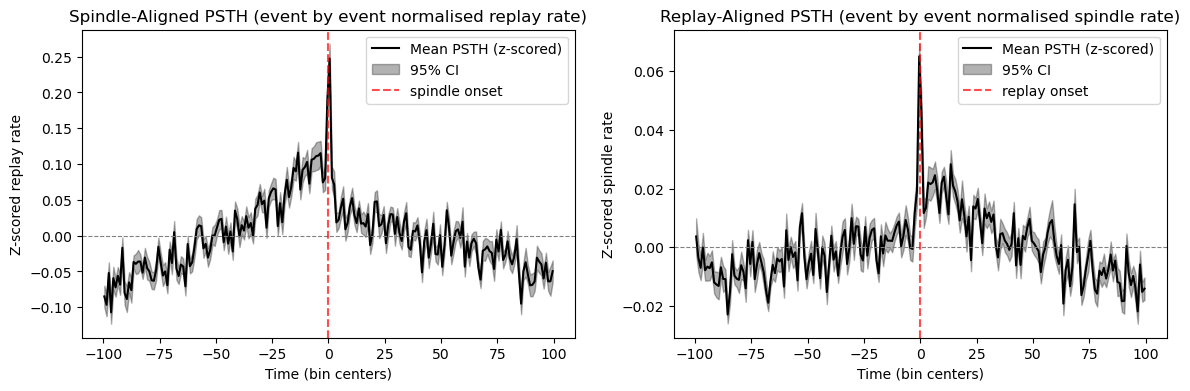

In [9]:
# average the event by event zscored data across trials for each mouse:
items = []
for item in event_by_event_zscored_psth_spindles:
    items +=[np.nanmean(item,axis=0)]

# average these across mice 
mean_psth_spin = np.nanmean(items, axis=0)
std_psth_spin = np.nanstd(items, axis=0)
n_trials_spin = len(np.nanmean(items,axis=0))
stderr_psth_spin = std_psth_spin / np.sqrt(n_trials_spin)
# Compute 95% confidence intervals
ci95_upper_spin = mean_psth_spin + 1.96 * stderr_psth_spin
ci95_lower_spin = mean_psth_spin - 1.96 * stderr_psth_spin

# Plotting
fig,[ax,ax2]= plt.subplots(1, 2,figsize=(14, 4))
ax.plot(event_by_event_psth_spindle_bins[0], mean_psth_spin, label='Mean PSTH (z-scored)', color='k')
ax.fill_between(event_by_event_psth_spindle_bins[0], ci95_lower_spin, ci95_upper_spin, alpha=0.3, color='k', label='95% CI')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0,color = 'red',linestyle='--', alpha = 0.7, label = 'spindle onset')
ax.set_xlabel('Time (bin centers)')
ax.set_ylabel('Z-scored replay rate')
ax.set_title('Spindle-Aligned PSTH (event by event normalised replay rate)')
ax.legend()
# ax.set_xlim(-20,20)


#### same again but inverse

items = []
for item in event_by_event_zscored_psth_replay:
    items +=[np.nanmean(item,axis=0)]
mean_psth_rply = np.nanmean(items, axis=0)
std_psth_rply = np.nanstd(items, axis=0)
n_trials_rply = len(np.nanmean(items,axis=0))

stderr_psth_rply = std_psth_rply / np.sqrt(n_trials_rply)
# Compute 95% confidence intervals
ci95_upper_rply = mean_psth_rply + 1.96 * stderr_psth_rply
ci95_lower_rply = mean_psth_rply - 1.96 * stderr_psth_rply

# Plotting

ax2.plot(event_by_event_psth_replay_bins[0], mean_psth_rply, label='Mean PSTH (z-scored)', color='k')
ax2.fill_between(event_by_event_psth_replay_bins[0], ci95_lower_rply, ci95_upper_rply, alpha=0.3, color='k', label='95% CI')
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax2.axvline(0,color = 'red',linestyle='--', alpha = 0.7, label = 'replay onset')
ax2.set_xlabel('Time (bin centers)')
ax2.set_ylabel('Z-scored spindle rate')
ax2.set_title('Replay-Aligned PSTH (event by event normalised spindle rate)')
ax2.legend()
# ax2.set_xlim(-20,20)

# proportion of spindle linked replay

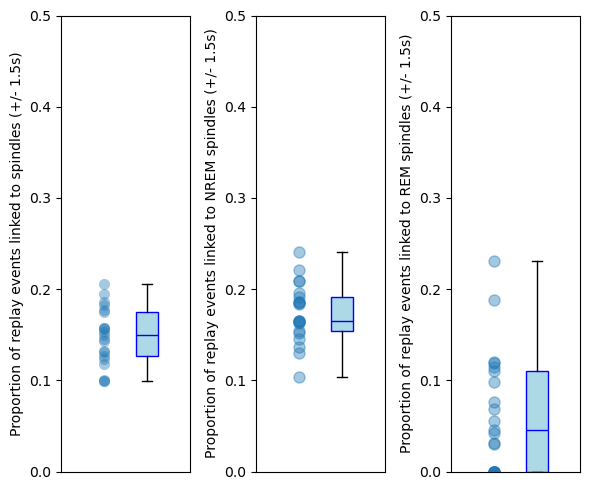

In [10]:
spin_linked_replay_total = [item[0] for item in proportion_of_spin_linked_replay_total_nrem_rem]
spin_linked_replay_total_nrem = [item[1] for item in proportion_of_spin_linked_replay_total_nrem_rem]
spin_linked_replay_total_rem = [item[2] for item in proportion_of_spin_linked_replay_total_nrem_rem]

fig,[ax,ax1,ax2],= plt.subplots(1, 3,figsize=(6, 5))
ax.plot(np.zeros(len(spin_linked_replay_total)),spin_linked_replay_total,'o', alpha = 0.4, markersize = 8,markeredgewidth = 0)
# add a box plot
ax.boxplot(spin_linked_replay_total, positions=[0.2], widths=0.1, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='blue'))
ax.set_ylim(0,0.5)
ax.set_xlim(-0.2,0.4)
# remove the x ticks
ax.set_xticks([])
ax.set_ylabel('Proportion of replay events linked to spindles (+/- 1.5s)')

ax1.plot(np.zeros(len(spin_linked_replay_total_nrem)),spin_linked_replay_total_nrem,'o', alpha = 0.4, markersize = 8)
# add a box plot
ax1.boxplot(spin_linked_replay_total_nrem, positions=[0.2], widths=0.1, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='blue'))
ax1.set_ylim(0,0.5)
ax1.set_xlim(-0.2,0.4)
# remove the x ticks
ax1.set_xticks([])
ax1.set_ylabel('Proportion of replay events linked to NREM spindles (+/- 1.5s)')

ax2.plot(np.zeros(len(spin_linked_replay_total_rem)),spin_linked_replay_total_rem,'o', alpha = 0.4, markersize = 8)
# add a box plot
ax2.boxplot(spin_linked_replay_total_rem, positions=[0.2], widths=0.1, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='blue'))
ax2.set_ylim(0,0.5)
ax2.set_xlim(-0.2,0.4)
# remove the x ticks
ax2.set_xticks([])
ax2.set_ylabel('Proportion of replay events linked to REM spindles (+/- 1.5s)')

#tight layout 
plt.tight_layout()

SaveFig('proportion_events_linked.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")


# spindle power and magnitude during replay windows

In [11]:
# extract replay window data
replay_window_mean_spectral_power,replay_window_mean_spectral_power_zscored,mean_spindle_magnitude = [],[],[]
replay_window_mean_spectral_power_nrem,replay_window_mean_spectral_power_zscored_nrem,mean_spindle_magnitude_nrem = [],[],[]
replay_window_mean_spectral_power_rem,replay_window_mean_spectral_power_zscored_rem,mean_spindle_magnitude_rem = [],[],[]
for array_ in replay_window_results:
    current_dict = array_.item()
    #general 
    replay_window_mean_spectral_power += [np.mean(current_dict['replay_window_mean_spectral_power'])]
    replay_window_mean_spectral_power_zscored += [np.mean(current_dict['replay_window_mean_spectral_power_zscored'])]
    mean_spindle_magnitude += [np.mean(current_dict['mean_spindle_magnitude'])]
    #nrem
    replay_window_mean_spectral_power_nrem += [np.mean(current_dict['replay_window_mean_spectral_power_nrem'])]
    replay_window_mean_spectral_power_zscored_nrem += [np.mean(current_dict['replay_window_mean_spectral_power_zscored_nrem'])]
    mean_spindle_magnitude_nrem += [np.mean(current_dict['mean_spindle_magnitude_nrem'])]
    #rem
    replay_window_mean_spectral_power_rem += [np.nanmean(current_dict['replay_window_mean_spectral_power_rem'])]
    replay_window_mean_spectral_power_zscored_rem += [np.nanmean(current_dict['replay_window_mean_spectral_power_zscored_rem'])]
    mean_spindle_magnitude_rem += [np.nanmean(current_dict['mean_spindle_magnitude_rem'])]
    
# do the same for the randomised data

rand_replay_window_mean_spectral_power,rand_replay_window_mean_spectral_power_zscored,rand_mean_spindle_magnitude = [],[],[]
rand_replay_window_mean_spectral_power_nrem,rand_replay_window_mean_spectral_power_zscored_nrem,rand_mean_spindle_magnitude_nrem = [],[],[]
rand_replay_window_mean_spectral_power_rem,rand_replay_window_mean_spectral_power_zscored_rem,rand_mean_spindle_magnitude_rem = [],[],[]
for ind, array_ in enumerate(rand_replay_window_results):
    current_dict = array_.item()
    #general 
    rand_replay_window_mean_spectral_power += [np.mean(current_dict['replay_window_mean_spectral_power'])]
    rand_replay_window_mean_spectral_power_zscored += [np.mean(current_dict['replay_window_mean_spectral_power_zscored'])]
    rand_mean_spindle_magnitude += [np.mean(current_dict['mean_spindle_magnitude'])]
    #nrem
    rand_replay_window_mean_spectral_power_nrem += [np.mean(current_dict['replay_window_mean_spectral_power_nrem'])]
    rand_replay_window_mean_spectral_power_zscored_nrem += [np.mean(current_dict['replay_window_mean_spectral_power_zscored_nrem'])]
    rand_mean_spindle_magnitude_nrem += [np.mean(current_dict['mean_spindle_magnitude_nrem'])]
    #rem
    rand_replay_window_mean_spectral_power_rem += [np.mean(current_dict['replay_window_mean_spectral_power_rem'])]
    rand_replay_window_mean_spectral_power_zscored_rem += [np.mean(current_dict['replay_window_mean_spectral_power_zscored_rem'])]
    rand_mean_spindle_magnitude_rem += [np.mean(current_dict['mean_spindle_magnitude_rem'])]
    
# replace any nan values with 0:
replay_window_mean_spectral_power = np.nan_to_num(replay_window_mean_spectral_power, nan=0.0)
replay_window_mean_spectral_power_zscored = np.nan_to_num(replay_window_mean_spectral_power_zscored, nan=0.0)
mean_spindle_magnitude = np.nan_to_num(mean_spindle_magnitude, nan=0.0)
replay_window_mean_spectral_power_nrem = np.nan_to_num(replay_window_mean_spectral_power_nrem, nan=0.0)
replay_window_mean_spectral_power_zscored_nrem = np.nan_to_num(replay_window_mean_spectral_power_zscored_nrem, nan=0.0)
mean_spindle_magnitude_nrem = np.nan_to_num(mean_spindle_magnitude_nrem, nan=0.0)
replay_window_mean_spectral_power_rem = np.nan_to_num(replay_window_mean_spectral_power_rem, nan=0.0)
replay_window_mean_spectral_power_zscored_rem = np.nan_to_num(replay_window_mean_spectral_power_zscored_rem, nan=0.0)
mean_spindle_magnitude_rem = np.nan_to_num(mean_spindle_magnitude_rem, nan=0.0)
#same fpr the randomised data
rand_replay_window_mean_spectral_power = np.nan_to_num(rand_replay_window_mean_spectral_power, nan=0.0)
rand_replay_window_mean_spectral_power_zscored = np.nan_to_num(rand_replay_window_mean_spectral_power_zscored, nan=0.0)
rand_mean_spindle_magnitude = np.nan_to_num(rand_mean_spindle_magnitude, nan=0.0)
rand_replay_window_mean_spectral_power_nrem = np.nan_to_num(rand_replay_window_mean_spectral_power_nrem, nan=0.0)
rand_replay_window_mean_spectral_power_zscored_nrem = np.nan_to_num(rand_replay_window_mean_spectral_power_zscored_nrem, nan=0.0)
rand_mean_spindle_magnitude_nrem = np.nan_to_num(rand_mean_spindle_magnitude_nrem, nan=0.0)
rand_replay_window_mean_spectral_power_rem = np.nan_to_num(rand_replay_window_mean_spectral_power_rem, nan=0.0)
rand_replay_window_mean_spectral_power_zscored_rem = np.nan_to_num(rand_replay_window_mean_spectral_power_zscored_rem, nan=0.0)
rand_mean_spindle_magnitude_rem = np.nan_to_num(rand_mean_spindle_magnitude_rem, nan=0.0)




C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_60848\3941395426.py:16: RuntimeWarning: Mean of empty slice
  replay_window_mean_spectral_power_rem += [np.nanmean(current_dict['replay_window_mean_spectral_power_rem'])]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_60848\3941395426.py:17: RuntimeWarning: Mean of empty slice
  replay_window_mean_spectral_power_zscored_rem += [np.nanmean(current_dict['replay_window_mean_spectral_power_zscored_rem'])]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_60848\3941395426.py:18: RuntimeWarning: Mean of empty slice
  mean_spindle_magnitude_rem += [np.nanmean(current_dict['mean_spindle_magnitude_rem'])]
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type

plots

wilcoxn
{'test': 'Wilcoxon signed-rank', 'W': np.float64(0.0), 'p': np.float64(9.5367431640625e-07), 'rank_biserial_r': np.float64(1.0)}
9.5367431640625e-07


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_60848\2813663062.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print({"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]})


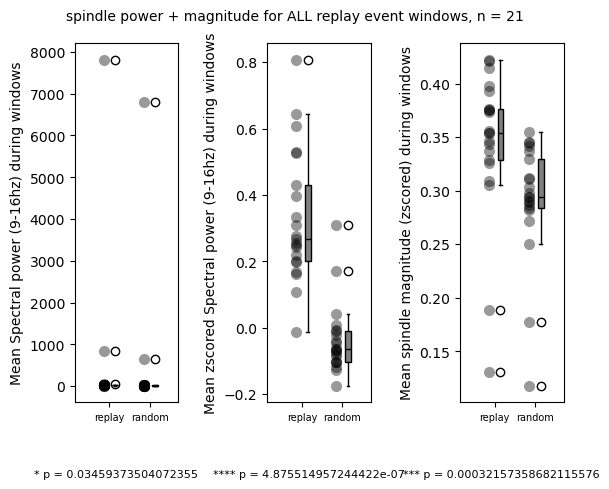

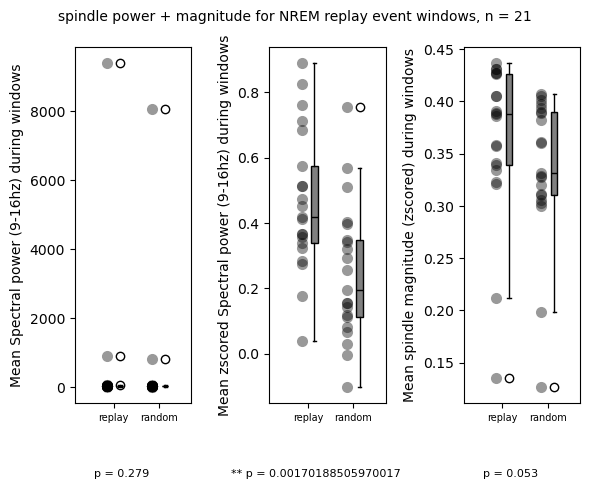

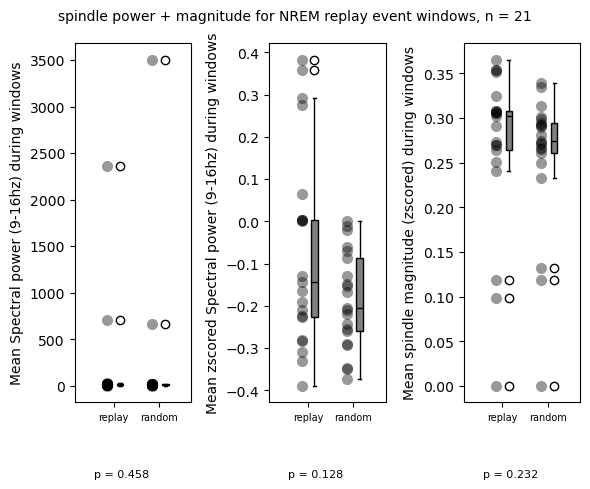

In [12]:
import pingouin as pg

fig,ax,= plt.subplots(1, 3,figsize=(6, 5))
plot_window_data(ax[0],replay_window_mean_spectral_power,rand_replay_window_mean_spectral_power,'Mean Spectral power (9-16hz) during windows')
plot_window_data(ax[1],replay_window_mean_spectral_power_zscored,rand_replay_window_mean_spectral_power_zscored,'Mean zscored Spectral power (9-16hz) during windows')
plot_window_data(ax[2],mean_spindle_magnitude,rand_mean_spindle_magnitude,'Mean spindle magnitude (zscored) during windows')
# add a title to the figure
fig.suptitle(f'spindle power + magnitude for ALL replay event windows, n = {n}', fontsize=10)
plt.tight_layout()

SaveFig('magnitude_vs_replay_windows.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")


_,p = shapiro(mean_spindle_magnitude)
_,p2 = shapiro(rand_mean_spindle_magnitude)

if p > 0.05 and p2 > 0.05:
    # do a paramtetic test 
    t_stat, p_value = stats.ttest_rel(mean_spindle_magnitude, rand_mean_spindle_magnitude)
    print('paired t test')
else:
    # do a non parametric test 
    t_stat, p_value = stats.wilcoxon(mean_spindle_magnitude, rand_mean_spindle_magnitude)
    print('wilcoxn')
    res = pg.wilcoxon(mean_spindle_magnitude, rand_mean_spindle_magnitude, alternative='two-sided')
    print({"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]})

print(p_value)


fig,ax,= plt.subplots(1, 3,figsize=(6, 5))
plot_window_data(ax[0],replay_window_mean_spectral_power_nrem,rand_replay_window_mean_spectral_power_nrem,'Mean Spectral power (9-16hz) during windows')
plot_window_data(ax[1],replay_window_mean_spectral_power_zscored_nrem,rand_replay_window_mean_spectral_power_zscored_nrem,'Mean zscored Spectral power (9-16hz) during windows')
plot_window_data(ax[2],mean_spindle_magnitude_nrem,rand_mean_spindle_magnitude_nrem,'Mean spindle magnitude (zscored) during windows')
# add a title to the figure
fig.suptitle(f'spindle power + magnitude for NREM replay event windows, n = {n}', fontsize=10)
plt.tight_layout()


fig,ax,= plt.subplots(1, 3,figsize=(6, 5))
plot_window_data(ax[0],replay_window_mean_spectral_power_rem,rand_replay_window_mean_spectral_power_rem,'Mean Spectral power (9-16hz) during windows')
plot_window_data(ax[1],replay_window_mean_spectral_power_zscored_rem,rand_replay_window_mean_spectral_power_zscored_rem,'Mean zscored Spectral power (9-16hz) during windows')
plot_window_data(ax[2],mean_spindle_magnitude_rem,rand_mean_spindle_magnitude_rem,'Mean spindle magnitude (zscored) during windows')
# add a title to the figure
fig.suptitle(f'spindle power + magnitude for NREM replay event windows, n = {n}', fontsize=10)
plt.tight_layout()




In [73]:
mean_spindle_magnitude

array([0.39326479, 0.35595778, 0.18811805, 0.3972565 , 0.3260582 ,
       0.30879961, 0.35350133, 0.32820389, 0.35426231, 0.37531513,
       0.42243201, 0.42068957, 0.30550014, 0.33728641, 0.34627682,
       0.3439036 , 0.41431453, 0.37586067, 0.37301728, 0.37493334,
       0.13037021])

# spindle amplitude + magnitude vs proximity to replay 


(0.0, 3.0)

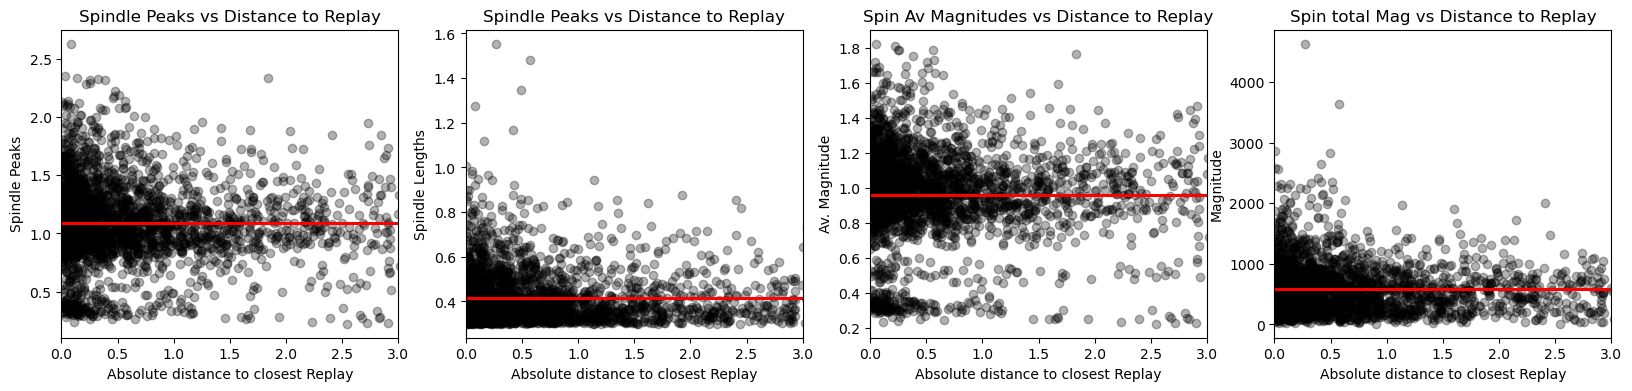

In [45]:
fig,[ax,ax2,ax3, ax4]= plt.subplots(1, 4,figsize=(20, 4))

all_dists = []
all_peaks = []
for i in range(len(distance_to_replay)):
    ax.plot(abs(distance_to_replay[i]), chunk_spind_peaks[i], 'o', alpha=0.3, color = 'k')
    all_dists += list(distance_to_replay[i])
    all_peaks += list(chunk_spind_peaks[i])  
#plot a regression line 
slope, intercept, r_value, p_value, std_err = stats.linregress(all_dists, all_peaks)
ax.plot(all_dists, slope * np.array(all_dists) + intercept, 'r-', label='Regression Line')
ax.set_xlabel('Absolute distance to closest Replay')
ax.set_ylabel('Spindle Peaks')
ax.set_title('Spindle Peaks vs Distance to Replay')
ax.set_xlim(0,3)    

all_dists = []
all_lengths = []
for i in range(len(distance_to_replay)):
    ax2.plot(abs(distance_to_replay[i]), chunk_spind_lengths[i], 'o', alpha=0.3, color = 'k')
    all_dists += list(distance_to_replay[i])
    all_lengths += list(chunk_spind_lengths[i])  
#plot a regression line 
slope, intercept, r_value, p_value, std_err = stats.linregress(all_dists, all_lengths)
ax2.plot(all_dists, slope * np.array(all_dists) + intercept, 'r-', label='Regression Line')
ax2.set_xlabel('Absolute distance to closest Replay')
ax2.set_ylabel('Spindle Lengths')
ax2.set_title('Spindle Peaks vs Distance to Replay')
ax2.set_xlim(0,3)    

all_dists = []
all_av_mags = []
for i in range(len(distance_to_replay)):
    ax3.plot(abs(distance_to_replay[i]), chunk_spind_av_magnitudes[i], 'o', alpha=0.3, color = 'k')
    all_dists += list(distance_to_replay[i])
    all_av_mags += list(chunk_spind_av_magnitudes[i])  
#plot a regression line 
slope, intercept, r_value, p_value, std_err = stats.linregress(all_dists, all_av_mags)
ax3.plot(all_dists, slope * np.array(all_dists) + intercept, 'r-', label='Regression Line')
ax3.set_xlabel('Absolute distance to closest Replay')
ax3.set_ylabel('Av. Magnitude')
ax3.set_title('Spin Av Magnitudes vs Distance to Replay')
ax3.set_xlim(0,3)    

all_dists = []
all_mags = []
for i in range(len(distance_to_replay)):
    ax4.plot(abs(distance_to_replay[i]), chunk_spind_total_magnitude[i], 'o', alpha=0.3, color = 'k')
    all_dists += list(distance_to_replay[i])
    all_mags += list(chunk_spind_total_magnitude[i])  
#plot a regression line 
slope, intercept, r_value, p_value, std_err = stats.linregress(all_dists, all_mags)
ax4.plot(all_dists, slope * np.array(all_dists) + intercept, 'r-', label='Regression Line')
ax4.set_xlabel('Absolute distance to closest Replay')
ax4.set_ylabel('Magnitude')
ax4.set_title('Spin total Mag vs Distance to Replay')
ax4.set_xlim(0,3)   




# average event triggered average

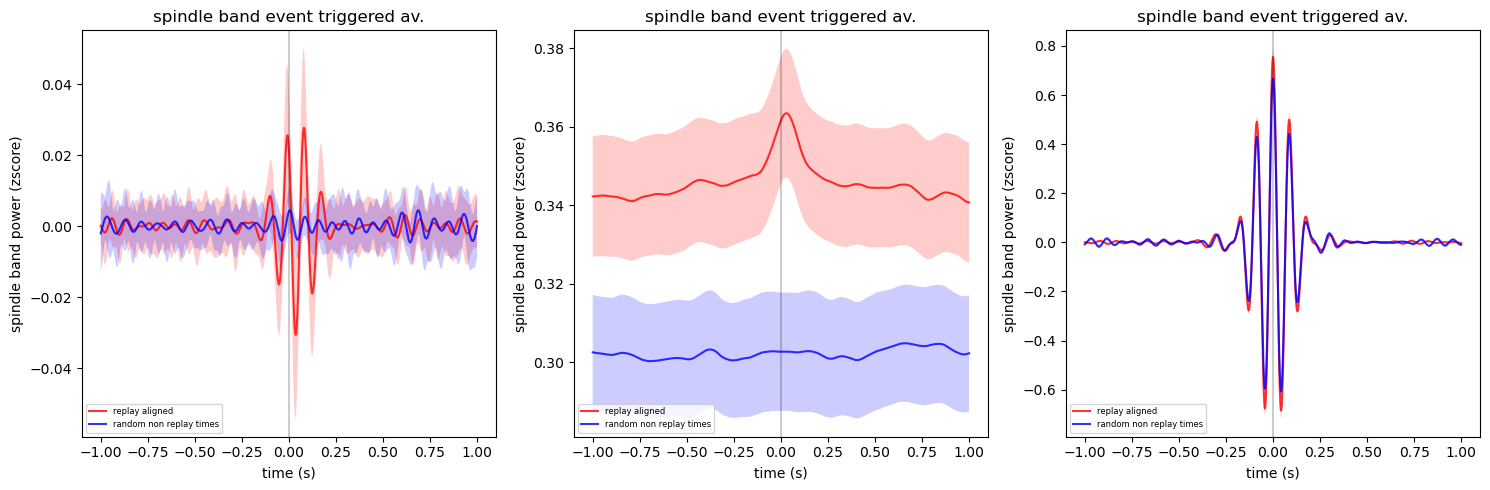

In [78]:
fig,ax= plt.subplots(1, 3,figsize=(15, 5))

mean_signal_across_all = np.mean(average_signal,axis = 0)
sem_across_all = stats.sem(average_signal,axis = 0)
std_across_all = np.std(average_signal,axis = 0)
random_mean_signal_across_all = np.mean(random_average_signal,axis = 0)
random_std_across_all = np.std(random_average_signal,axis = 0)
plot_ETA(ax[0],mean_signal_across_all,std_across_all,random_mean_signal_across_all,random_std_across_all)

start_y = 0
end_y = np.std(random_mean_signal_across_all)
x_value = 0  # You can also use np.min(spindle_bandpassed[...]) - margin

plt.plot([x_value, x_value], [start_y, end_y], color='k', linewidth=3)



mean_rectsignal_across_all = np.mean(average_signal_rect,axis = 0)
rectsem_across_all = stats.sem(average_signal_rect,axis = 0)
random_mean_rectsignal_across_all = np.mean(random_average_signal_rect,axis = 0)
random_rectsem_across_all = stats.sem(random_average_signal_rect,axis = 0)
plot_ETA(ax[1],mean_rectsignal_across_all,rectsem_across_all,random_mean_rectsignal_across_all,random_rectsem_across_all)

mean_peakaligned_across_all = np.mean(peak_algined_average_signal,axis = 0)
sem_peakaligned_across_all = stats.sem(peak_algined_average_signal,axis = 0)
rand_mean_peakaligned_across_all = np.mean(random_peak_algined_average_signal,axis = 0)
rand_sem_peakaligned_across_all = stats.sem(random_peak_algined_average_signal,axis = 0)
plot_ETA(ax[2],mean_peakaligned_across_all,sem_peakaligned_across_all,rand_mean_peakaligned_across_all,rand_sem_peakaligned_across_all)

plt.tight_layout()

SaveFig('spindle_eta.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")


In [47]:
np.std(random_mean_signal_across_all)

np.float64(0.0015867202871958303)

In [48]:
np.std(mean_signal_across_all)

np.float64(0.005628754931483552)

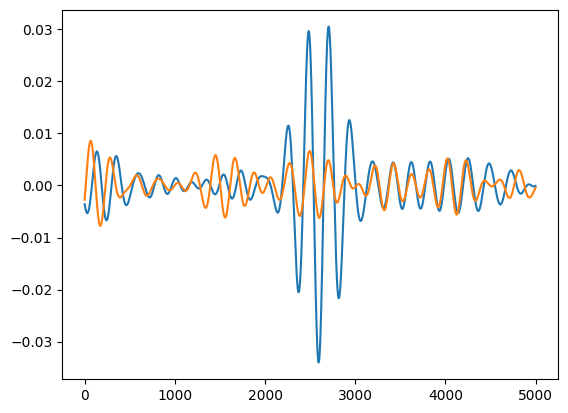

In [50]:
plt.plot(mean_signal_across_all)
plt.plot(random_mean_signal_across_all)

0.002802861070562515

In [28]:
np.mean(sem_across_all)

0.012838276019409569

# regression analysis coefficients 
do spindle features predict replay? 

Text(0, 0.5, 'AUC (area under the ROC curve)')

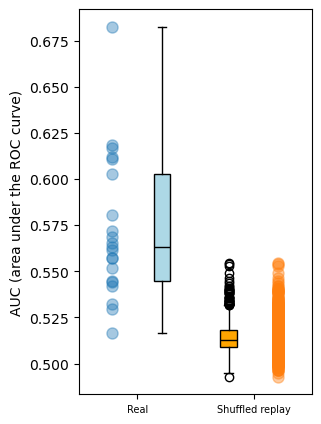

In [82]:
# flatten list
shuffled_aucs_flat = [item for sublist in shuffled_aucs for item in sublist]

fig,ax,= plt.subplots(1, 1,figsize=(3, 5))
ax.plot(np.zeros(len(original_auc)),original_auc,'o', alpha = 0.4, markersize = 8)
ax.plot(np.ones(len(shuffled_aucs_flat)),shuffled_aucs_flat,'o', alpha = 0.4, markersize = 8)
# add a box plot
ax.boxplot(original_auc, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='lightblue', color='k'), medianprops=dict(color='k'))
ax.boxplot(shuffled_aucs_flat, positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='orange', color='k'), medianprops=dict(color='k'))
# # remove the x ticks
ax.set_xticks([0.15,0.85])
# add x tick labels 
ax.set_xticklabels(['Real','Shuffled replay'], fontsize = 7)
ax.set_ylabel('AUC (area under the ROC curve)')



#

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_31796\3353278634.py:19: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_31796\3353278634.py:19: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(


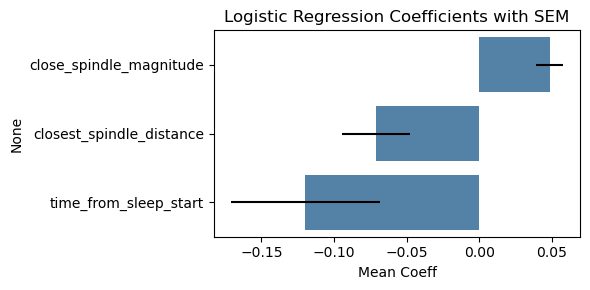

In [80]:
import seaborn as sns

df_params = pd.DataFrame([res.params for res in logistic_regression_results_objects])

# Drop the constant term if it exists
df_plot = df_params.drop(columns='const', errors='ignore')

# Compute mean and SEM for each parameter
mean_values = df_plot.mean()
sem_values = df_plot.sem()

# Sort by mean values
sorted_indices = mean_values.sort_values(ascending=False).index
mean_sorted = mean_values[sorted_indices]
sem_sorted = sem_values[sorted_indices]

# Plot with error bars
plt.figure(figsize=(6, 3))
sns.barplot(
    x=mean_sorted.values,
    y=mean_sorted.index,
    xerr=sem_sorted.values,
    color='steelblue',
    capsize=0.2,
    errcolor='black',
    errwidth=1
)
plt.xlabel('Mean Coeff')
plt.title('Logistic Regression Coefficients with SEM')
plt.tight_layout()
plt.show()



# linkage between spindles neuron consistency 

Text(0.5, 0, 'unit consistency in awake')

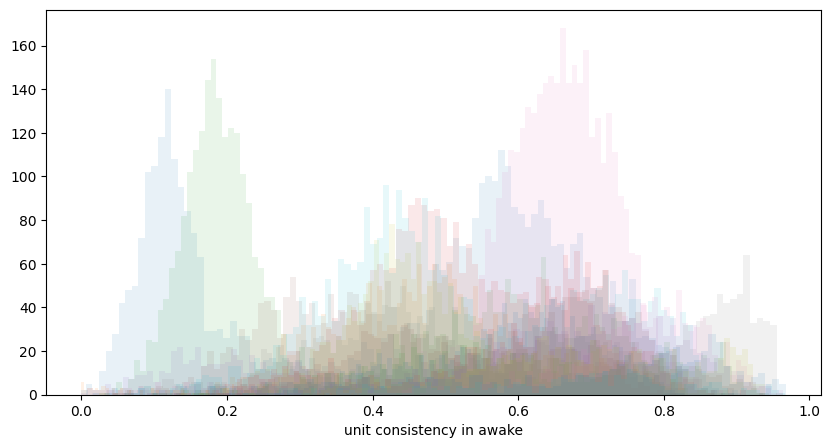

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for uc_ in unit_consistency_awake:
    ax.hist(uc_,100,alpha = 0.1)
ax.set_xlabel('unit consistency in awake')

spindle linkage distance vs awake consistency 

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_33684\3340673295.py:4: RuntimeWarning: Mean of empty slice
  mean_linkage_distance = np.nanmean(spindle_linkage_distance_vs_consistency, axis=0)
c:\miniconda\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(0.0, 0.9)

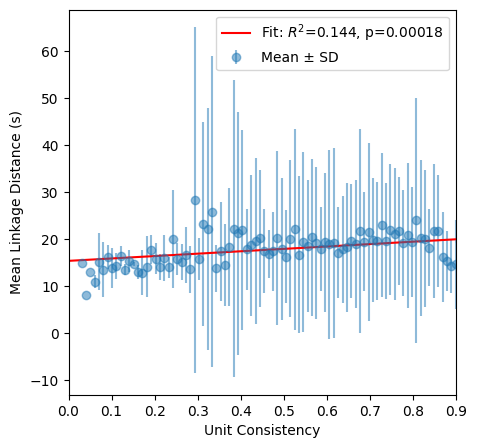

In [76]:
import statsmodels.api as sm

# Prepare data
mean_linkage_distance = np.nanmean(spindle_linkage_distance_vs_consistency, axis=0)
std_linkage_distance = np.nanstd(spindle_linkage_distance_vs_consistency, axis=0)
x_vals = np.linspace(0, 1, 100)

# Build DataFrame
df = pd.DataFrame({
    'x': x_vals,
    'y': mean_linkage_distance,
    'std': std_linkage_distance
})

# Set up plot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot points with error bars
ax.errorbar(df['x'], df['y'], yerr=df['std'], fmt='o', alpha=0.5, label='Mean ± SD')

# Prepare data for regression
X = sm.add_constant(df['x'])  # adds intercept term
model = sm.OLS(df['y'], X, missing='drop')
results = model.fit()

# Regression line
df['y_pred'] = results.predict(X)

# Plot regression line
ax.plot(df['x'], df['y_pred'], color='red',
        label=f'Fit: $R^2$={results.rsquared:.3f}, p={results.pvalues["x"]:.3g}')

# Labels and legend
ax.set_xlabel('Unit Consistency')
ax.set_ylabel('Mean Linkage Distance (s)')
ax.legend()
ax.set_xlim(0,0.9)


linkage proportion vs awake consistency 

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_33684\2822413173.py:4: RuntimeWarning: Mean of empty slice
  mean_linkage_distance = np.nanmean(proportion_spindle_linked_vs_consistency, axis=0)
c:\miniconda\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(0.1, 0.9)

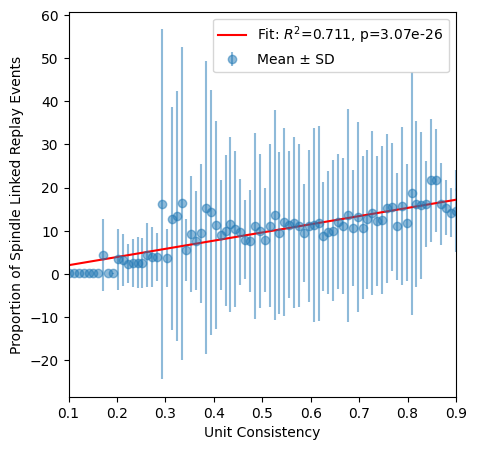

In [83]:
import statsmodels.api as sm

# Prepare data
mean_linkage_distance = np.nanmean(proportion_spindle_linked_vs_consistency, axis=0)
std_linkage_distance = np.nanstd(proportion_spindle_linked_vs_consistency, axis=0)
x_vals = np.linspace(0, 1, 100)

# Build DataFrame
df = pd.DataFrame({
    'x': x_vals,
    'y': mean_linkage_distance,
    'std': std_linkage_distance
})

# Set up plot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot points with error bars
ax.errorbar(df['x'], df['y'], yerr=df['std'], fmt='o', alpha=0.5, label='Mean ± SD')

# Prepare data for regression
X = sm.add_constant(df['x'])  # adds intercept term
model = sm.OLS(df['y'], X, missing='drop')
results = model.fit()

# Regression line
df['y_pred'] = results.predict(X)

# Plot regression line
ax.plot(df['x'], df['y_pred'], color='red',
        label=f'Fit: $R^2$={results.rsquared:.3f}, p={results.pvalues["x"]:.3g}')

# Labels and legend
ax.set_xlabel('Unit Consistency')
ax.set_ylabel('Proportion of Spindle Linked Replay Events')
ax.legend()
ax.set_xlim(0.1,0.9)

# does being spindle linked change the replay? 

Text(0, 0.5, 'AUC (area under the ROC curve)')

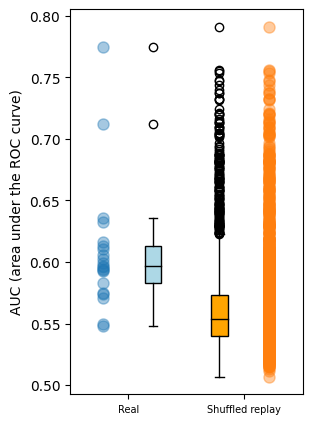

In [78]:
# flatten list
shuffled_aucs_flat = [item for sublist in replay_predicts_linkage_shuffled_aucs for item in sublist]

fig,ax,= plt.subplots(1, 1,figsize=(3, 5))
ax.plot(np.zeros(len(replay_predicts_linkage_original_auc)),replay_predicts_linkage_original_auc,'o', alpha = 0.4, markersize = 8)
ax.plot(np.ones(len(shuffled_aucs_flat)),shuffled_aucs_flat,'o', alpha = 0.4, markersize = 8)
# add a box plot
ax.boxplot(replay_predicts_linkage_original_auc, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='lightblue', color='k'), medianprops=dict(color='k'))
ax.boxplot(shuffled_aucs_flat, positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='orange', color='k'), medianprops=dict(color='k'))
# # remove the x ticks
ax.set_xticks([0.15,0.85])
# add x tick labels 
ax.set_xticklabels(['Real','Shuffled replay'], fontsize = 7)
ax.set_ylabel('AUC (area under the ROC curve)')


In [79]:
# it might be that a different motif was responsible each time...?
# also how can i get the missing motif value (motif 1?)
# what about if the motif is task related? Does this make a difference? 

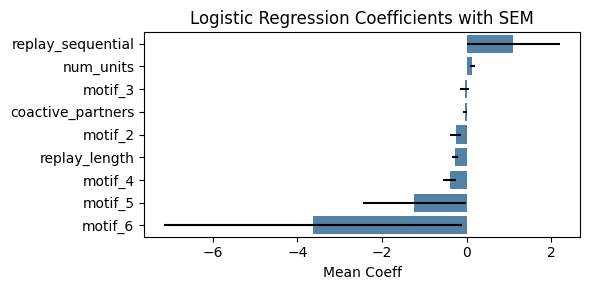

In [80]:
df_params = pd.DataFrame([res.params for res in replay_predicts_linkage_logistic_regression_results_object
])

# Drop the constant term if it exists
df_plot = df_params.drop(columns='const', errors='ignore')

# Compute mean and SEM for each parameter
mean_values = df_plot.mean()
sem_values = df_plot.sem()

# Sort by mean values
sorted_indices = mean_values.sort_values(ascending=False).index
mean_sorted = mean_values[sorted_indices]
sem_sorted = sem_values[sorted_indices]

# Plot with error bars
plt.figure(figsize=(6, 3))
sns.barplot(
    x=mean_sorted.values,
    y=mean_sorted.index,
    xerr=sem_sorted.values,
    color='steelblue',
    capsize=0.2,
    errcolor='black',
    errwidth=1
)
plt.xlabel('Mean Coeff')
plt.title('Logistic Regression Coefficients with SEM')
plt.tight_layout()
plt.show()

In [ ]:
replay_predicts_linkage_logistic_regression_results_object
replay_predicts_linkage_original_auc
replay_predicts_linkage_shuffled_aucs

In [ ]:
# regression analysis, use replay features as predictors
# and spindle 

# do features of replay preidct closeness to spindle?
# does closeness to spindle predict replay features?
# are these the same question? not sure



In [ ]:
# can we predict whether a spindle will occur based on replay features?
# spindle or not spidle - logistic regression
# predictors are all the features of replay


In [ ]:
# I dont need a regression for this. 
# in the end I think its actually just easier to take all the spindle linked replays and plot the features vs non spindle linked replays